# Creating the bayts probability time series and doing bayesian updating to refine the non forest probabilities for each pixel/date

/anaconda/envs/pybayts/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
100%|██████████| 22/22 [00:00<00:00, 563.89it/s]
/anaconda/envs/pybayts/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
100%|██████████| 100/100 [00:00<00:00, 117.42it/s]


decimal_yr_arr: [[          nan           nan           nan ...           nan
  2016.20765027 2016.20765027]
 [          nan           nan           nan ... 2016.01092896
  2016.01092896 2016.01092896]
 [          nan           nan           nan ... 2016.01092896
  2016.01092896 2016.01092896]
 ...
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]]


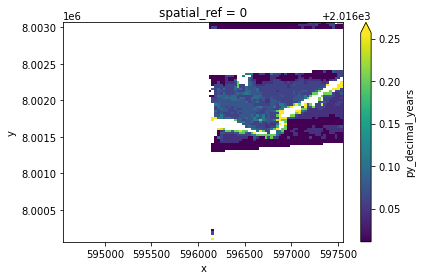

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import click
import xarray as xr
import rioxarray as rx

from pybayts.bayts import bayts_da_to_date_array
from pybayts.bayts import create_bayts_ts
from pybayts.bayts import deseason_ts
from pybayts.bayts import loop_bayts_update
from pybayts.bayts import merge_cpnf_tseries
from pybayts.data.io import read_and_stack_example_tifs


vv_folder = "../tests/baytsdata/s1vv_tseries/"
ndvi_folder = "../tests/baytsdata/lndvi_tseries/"
pdf_type_l = ("gaussian", "gaussian")
chi = .9
cpnf_min = .5
pdf_forest_l = (0, 0.1)  # mean and sd
pdf_nonforest_l = (-0.5, 0.125)  # mean and sd
bwf_l = (0.1, 0.9)
pdf_type_s = ("gaussian", "gaussian")
pdf_forest_s = (-1, 0.75)  # mean and sd
pdf_nonforest_s = (-4, 1)  # mean and sd
bwf_s = (0.1, 0.9)

s1vv_ts = read_and_stack_example_tifs(vv_folder, ds="vv")
s1vv_ts.name = "s1vv"

lndvi_ts = read_and_stack_example_tifs(ndvi_folder, ds="lndvi")
lndvi_ts.name = "lndvi"

_ = deseason_ts(s1vv_ts)
_ = deseason_ts(lndvi_ts)

cpnf_ts = merge_cpnf_tseries(
    s1vv_ts,
    lndvi_ts,
    pdf_type_l,
    pdf_type_s,
    pdf_forest_l,
    pdf_nonforest_l,
    pdf_forest_s,
    pdf_nonforest_s,
    bwf_l,
    bwf_s,
)

bayts = create_bayts_ts(cpnf_ts)

initial_change = xr.where(bayts >= 0.5, True, False)

monitor_start = datetime(2016, 1, 1)
flagged_change = loop_bayts_update(
    bayts.data,
    initial_change.data,
    initial_change.date.values,
    chi, cpnf_min,
    monitor_start,
)
bayts.name = "bayts"
baytsds = bayts.to_dataset()
baytsds = baytsds.sel(date=slice(monitor_start, None))
# Need a dataset for the date coordinates
baytsds["flagged_change"] = (("date", "y", "x"), flagged_change)

date_index_arr, actual_dates, decimal_yr_arr = bayts_da_to_date_array(baytsds)

print(f"decimal_yr_arr: {decimal_yr_arr}")

masked_bayts_r = rx.open_rasterio(
    "../tests/baytsdata/bayts_spatial_result.tif",
    masked=True,
)
r_results_ds = masked_bayts_r.to_dataset(dim="band")
r_results_ds["py_decimal_years"] = (("y", "x"), decimal_yr_arr)
r_results_ds["py_decimal_years"].plot.imshow(robust=True)
plt.tight_layout()

In [2]:
diff = abs(masked_bayts_r.sel(band=3) - r_results_ds["py_decimal_years"])

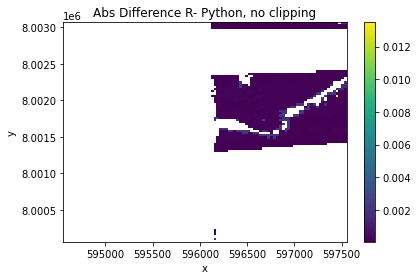

In [3]:
(diff).plot.imshow()
plt.title("Abs Difference R- Python, no clipping")
plt.tight_layout()
plt.savefig("baytsdiffnoclipping.jpg")

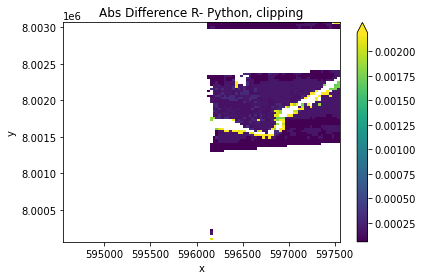

In [4]:
diff.plot.imshow(robust=True)
plt.title("Abs Difference R- Python, clipping")
plt.tight_layout()
plt.savefig("baytsdiffclipping.jpg")

# Example timeseries for a single pixel

In [19]:
from pybayts.data.io import read_single_pixel_csv
from pybayts.plot import plot_df_pixel_ts
ldf = read_single_pixel_csv("../tests/baytsdata/lndvi_singlepixel.csv", date_column="lndvi_date")
sdf = read_single_pixel_csv("../tests/baytsdata/s1vv_singlepixel.csv", date_column="s1vv_date")

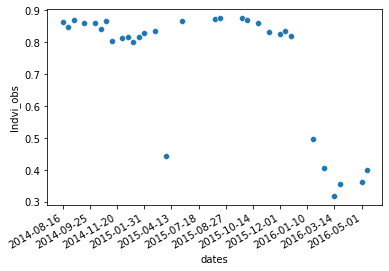

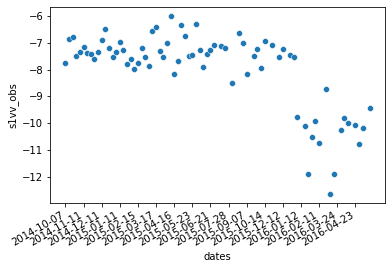

In [20]:
from pybayts import plot as pp
plot_df_pixel_ts(ldf, "lndvi_obs")
plot_df_pixel_ts(sdf, "s1vv_obs")